In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.colors as colors

import ripser
import persim

In [2]:
data = pd.read_csv('Papers/Connectome of an insect brain/Supplementary-Data-S1/all-all_connectivity_matrix.csv')
data = data.set_index('Unnamed: 0')
data.columns = data.columns.astype(int)
data


,29,8419602,9469519,15458316,4393049,4679139,15592696,17327188,15653288,10158972,...,5120097,15690955,15629888,15998913,15730680,15712024,15690392,15690711,5120990,11717035
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
29,0.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8419602,6.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9469519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15458316,0.0,0.0,0.0,0.0,8.0,15.0,0.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4393049,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15712024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15690392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15690711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:

# Assuming the dataframe is stored in the variable 'data'
# Remove the first column if it contains row indices
if 'Unnamed: 0' in data.columns:
    data = data.drop(columns=['Unnamed: 0'])

# Convert the dataframe to a dictionary
adjacency_dict = data.to_dict()

# Create an empty graph
G = nx.Graph()

# Add nodes to the graph
G.add_nodes_from(adjacency_dict.keys())

# Add edges to the graph
for source_node, target_nodes in adjacency_dict.items():
    for target_node, weight in target_nodes.items():
        if weight == 0:
            continue
        G.add_edge(source_node, target_node, weight=weight)

# Print the graph
print(G)


Graph with 2952 nodes and 96527 edges


Plot graph and weight histogram

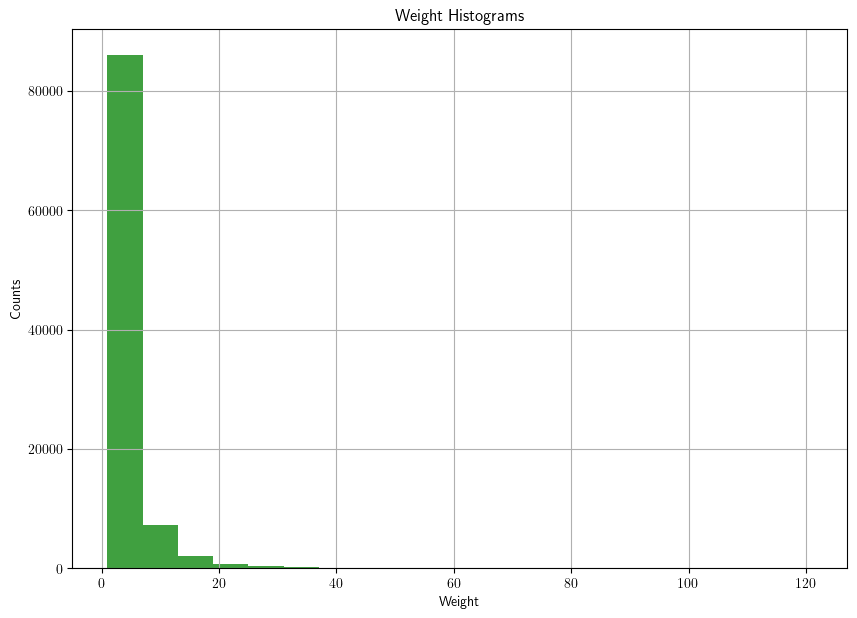

In [4]:
# edge weights
G_weights = [e[2]['weight'] for e in G.edges.data()]

fig, ax = plt.subplots(figsize=(10, 7))  # Create a single plot

# plot weight histogram
ax.hist(G_weights, bins=20, facecolor='g', alpha=0.75)
ax.set_title("Weight Histograms")
ax.set_xlabel("Weight")
ax.set_ylabel("Counts")
ax.grid()

plt.show()

In [32]:
subgraph_nodes = list(G.nodes())[:1000]
subgraph = G.subgraph(subgraph_nodes)

A = nx.adjacency_matrix(subgraph).copy().todense().astype(float)
A[A == 0] = np.inf
np.fill_diagonal(A, [0]*len(G))
A = np.array(np.round(A, 4))
print(f"is symmetric = {np.allclose(np.asarray(A.T), np.asarray(A))}")

is symmetric = True


In [33]:
def diagram_sizes(dgms):
    return ", ".join([f"|$H_{i}$|={len(d)}" for i, d in enumerate(dgms)])

In [34]:
# dgms = ripser.ripser(A, distance_matrix=True, maxdim=2)['dgms']
dgms = ripser.ripser(A, distance_matrix=True, maxdim=1)['dgms']
persim.plot_diagrams(
    dgms, show=True,
    title=f"PD of SF graph\n{diagram_sizes(dgms)}"
)


Complexity analysis:
200 - 0.9 s
300 - 2.9 s
400 - 7.3 s
500 - 24.7 s
600 - 98.1 s

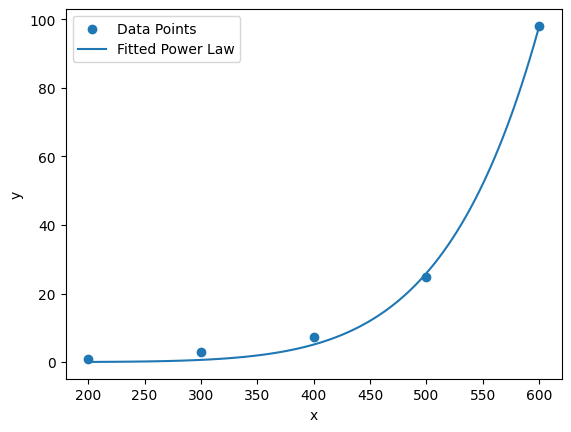

In [26]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the power law function
def power_law(x, a, b):
    return a * np.power(x, b)

# Define the data points
x = np.array([200, 300, 400, 500, 600])  # x values
y = np.array([0.9, 2.9, 7.4, 24.7, 98.1])  # y values

# Fit the power law function to the data points
params, _ = curve_fit(power_law, x, y, p0 = [1, 1], maxfev=10000)

# Extract the fitted parameters
a_fit, b_fit = params

# Generate the fitted curve
x_fit = np.linspace(min(x), max(x), 100)
y_fit = power_law(x_fit, a_fit, b_fit)

# Plot the data points and the fitted curve
plt.scatter(x, y, label='Data Points')
plt.plot(x_fit, y_fit, label='Fitted Power Law')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


In [25]:
print(params)

[5.50509522e-19 7.28904409e+00]


In [27]:
df2 = pd.read_csv('Papers/Connectome of an insect brain/Supplementary-Data-S1/aa_connectivity_matrix.csv')
df2

,Unnamed: 0,29,8419602,37365,2200028,40152,1414206,15997645,15998100,15997692,...,17223685,17304269,17355892,17543765,17639824,17732291,17736641,18123575,20911955,21591317
0,29,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,8419602,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,37365,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,2200028,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,40152,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,17732291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2948,17736641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2949,18123575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2950,20911955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
